**Svyat Skoblov**

**@error_derivative**

[ссылка на статью по TopSBM](https://arxiv.org/pdf/1708.01677.pdf)


In [1]:
import re
import sys 

import nltk
import pymorphy2 
import numpy as np 
import pandas as pd
import pylab as plt
import graph_tool.all as gt

from pprint import pprint
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


%matplotlib inline

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 300)

gt.seed_rng(64)

Модель не оформлена в виде пакета, к тому же использует graph tool. 


Рекомендуемый способ запуска модели - docker image *iagopeixoto/graph-tool*, однако, с ним возникает достаточно проблем (pygal, например, завести не удалось). 


Образ, в котором запускался этот notebook, собран на базе ubuntu cosmic (в dockerfile авторов используется archlinux).

In [2]:
sys.path.append('hSBM_Topicmodel')

from sbmtm import sbmtm

In [3]:
stopword_ru = stopwords.words('russian')
stopword_ru.append(['это', 'также'])

morph = pymorphy2.MorphAnalyzer()

cache = {}

In [4]:
def clean_text(text):
    '''
        очистка текста от мусора
    '''

    text = re.sub('-\s\r\n\|-\s\r\n|\r\n|[«»]|[""]|[><]"[\[]]|//"', '', str(text))
    text = re.sub('[«»]|[""]|[><]"[\[]]"', '', text)
    text = re.sub('[0-9]|[-.,:;_%©?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|"|–|—|', ' ', text)
    text = re.sub(r'\r\n\t|\n|\\s|\r\t|\\n', ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text)
    text = re.sub('ё', 'е', text.strip().lower())

    return text


def token_stop_pymorph(text):
    '''
        [0] токенизация предложения
        [1] проверка есть ли в начале слова '-'
        [2] проверка на стоп-слова
        [3] проверка есть ли данное слово в кэше
        [4] лемматизация слова
    на выходе лист токенов
    '''

    if not isinstance(text, str):
        text = str(text)
    words = word_tokenize(text)

    words_lem = []
    for w in words:
        if len(w) < 2:
            continue
        if w[0] == '-':
            w = w[1:]
        if w not in stopword_ru:
            if w in cache:
                words_lem.append(cache[w])
            else:
                temp_cache = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cache)
    return words_lem

In [5]:
data = pd.read_csv('news_lenta.csv')

In [6]:
date_regex = re.compile('(\d{4})/(\d{2})/(\d{2})')

data['date_raw'] = data['url'].apply(date_regex.findall)
data['year'] = data['date_raw'].apply(lambda x: int(x[0][0]))
data['month'] = data['date_raw'].apply(lambda x: int(x[0][1]))

In [7]:
data = data.query('year > 2007')

Возьмем подмножество данных. 

Ограничение на размер выборки обусловлено требованиями алгоритма по памяти и разумном времени выполнения (~4 часа на i7-7700k, при данном размере сэмпла расходуется примерно 30 гб RAM).

In [8]:
def sample_news(data: pd.DataFrame) -> pd.DataFrame:
    news = list()
    combined_date = data.year.astype(str) + data.month.astype(str)
    for date in combined_date.unique():
        sample = data.loc[combined_date == date].sample(85, random_state=0)
        news.append(sample)
    return pd.concat(news, axis=0, ignore_index=True)

In [9]:
news = sample_news(data)

In [10]:
corpus = [clean_text(s) for s in news.text]
corpus = [token_stop_pymorph(s) for s in corpus]

В качестве id текстов взяты заголовки - ради наглядности.  

In [ ]:
text_ids = [clean_text(s) for s in news.title]

In [11]:
len(corpus)

10795

Сам процесс обучения крайне прост - создание графа новостей и *fit*.

In [12]:
model = sbmtm()
model.make_graph(corpus, documents=text_ids)
model.fit(n_init=3)

Число уровней иерархии.

In [24]:
print(model.L)

4


Количество топиков подбирается автоматически.

In [23]:
pprint(model.topics(l=1, n=5))

{0: [('свой', 0.07844815290258166),
     ('однако', 0.058812342509390006),
     ('другой', 0.04721152474682642),
     ('несколько', 0.04671230922835544),
     ('день', 0.038439594922265015)],
 1: [('больница', 0.044013350020859404),
     ('доставить', 0.034626616604088445),
     ('травма', 0.03295786399666249),
     ('водитель', 0.025657071339173967),
     ('милиция', 0.024509803921568627)],
 2: [('аэропорт', 0.0345797679052866),
     ('пассажир', 0.032704255069745634),
     ('борт', 0.03223537686086039),
     ('транспорт', 0.02508498417536045),
     ('экипаж', 0.021451178056499823)],
 3: [('выйти', 0.08211288464702979),
     ('роль', 0.03340464044758927),
     ('серия', 0.0328286983709067),
     ('нью', 0.025999670890241897),
     ('передача', 0.02493006417640283)],
 4: [('участие', 0.07929248772614164),
     ('пройти', 0.07350864214136794),
     ('состояться', 0.06577443002219382),
     ('участник', 0.050306005783845587),
     ('проходить', 0.048288385231017555)],
 5: [('секунда', 0.

In [27]:
pprint(model.topics(l=2, n=5))

{0: [('который', 0.021793422169620245),
     ('сообщать', 0.020574653126353943),
     ('один', 0.014833053298249693),
     ('время', 0.013078871264877964),
     ('стать', 0.012430739750539816)],
 1: [('летний', 0.022408026755852843),
     ('полиция', 0.017094017094017096),
     ('погибнуть', 0.013507989594946116),
     ('мужчина', 0.011835748792270532),
     ('женщина', 0.011055369751021924)],
 2: [('самолёт', 0.012954164007280807),
     ('километр', 0.01111032314493062),
     ('оружие', 0.010472070538732477),
     ('метр', 0.008604590690967544),
     ('взрыв', 0.007304446493156514)],
 3: [('выйти', 0.022425958383892858),
     ('главный', 0.021032762572468652),
     ('фильм', 0.012471349602265067),
     ('занимать', 0.012381466001528021),
     ('хороший', 0.011212979191946429)],
 4: [('человек', 0.03535251094698913),
     ('находиться', 0.02195363487764428),
     ('сайт', 0.02181045899800747),
     ('результат', 0.021452519298915444),
     ('место', 0.02005655447245654)],
 5: [('команд

Авторами реализована возможность кластеризации документов (именно поэтому использованы заголовки), выглядит довольно хорошо.

In [14]:
pprint(model.clusters(l=1, n=3))

{0: [('вьетнамцы нашли тонну змей на борту самолета', 1.0),
     ('сомалийские пираты отпустили сухогруз с украинским экипажем', 1.0),
     ('в сети появилась видеозапись взрыва в домодедово', 1.0)],
 1: [('катар заявил о праве на российские с', 1.0),
     ('россия усомнилась в подлинности заявления юлии скрипаль', 1.0),
     ('россия отказалась поддержать принятие косово в фифа', 1.0)],
 2: [('путин разрешил total добывать газ на ямале', 1.0),
     ('глава exxon mobil раскритиковал нефтяную политику джорджа буша', 1.0),
     ('экспорт нефти и газа из россии сократился вопреки росту добычи', 1.0)],
 3: [('в сети составили список секс советов для мужчин в стиле cosmopolitan',
      1.0),
     ('тело шаинского вернут из сша в россию', 1.0),
     ('в москве пройдет секретная вечеринка boiler room', 1.0)],
 4: [('кокорин после извинений за кутеж в монако решил купить mercedes за    '
      'миллионов',
      1.0),
     ('у фанатов барселоны в италии изъяли оружие первобытных людей', 1.0),


Подготовим данные для визуализации.

In [15]:
def extract_topic_names(model):
    topics = model.topics(l=1, n=5)
    result = list()
    for key, word_list in topics.items():
        words, _= zip(*word_list)
        topic_name = ', '.join(words)
        result.append(topic_name)
    return result

In [16]:
topic_names = extract_topic_names(model)

In [17]:
def create_topic_matrix(model, hierarchy_level=1):
    topics_matrix = list()
    num_of_topics, corpus_size = model.groups[hierarchy_level]['p_tw_d'].shape

    for ind in range(0, corpus_size):
        topic_dist = model.topicdist(ind, l=hierarchy_level)
        _, topic_dist = zip(*topic_dist)
        topics_matrix.append(topic_dist)
    
    cols = ['topic_{}'.format(x) for x in range(0, num_of_topics)]
    topics_matrix = pd.DataFrame(topics_matrix, columns=cols)
    return topics_matrix, cols

In [18]:
topics_matrix, topic_cols = create_topic_matrix(model)
topics_matrix['year'] = news['year']
topics_matrix['month'] = news['month']

In [20]:
from pygal import StackedLine
from pygal.style import Style
from IPython.display import SVG, HTML

**Pygal**

In [21]:
html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [22]:
vis_data = topics_matrix.groupby(['year', 'month'])[topic_cols].sum()
time_labels = vis_data.index.to_frame().astype(str).apply(lambda t: '-'.join(t), axis=1)
topic_names = { topic: name for topic, name in zip(topic_cols, topic_names)}

line_chart = StackedLine(fill=True, show_dots=False,
                         stroke_style={'width': 0.5},
                         style=Style(legend_font_size=6),
                         legend_at_bottom=True, x_label_rotation=90,
                         x_labels_major_every=6,
                         show_minor_x_labels=False)

line_chart.title = 'Topics'
line_chart.x_labels = time_labels.values
for topic in topic_cols:
    line_chart.add(topic_names[topic], vis_data[topic].values)

HTML(html_pygal.format(pygal_render=line_chart.render(is_unicode=True)))

На графике виден резкий рост тем, связанных с Украиной (с конца 2013 года). С середины 2015 года возрастает число новостей на тему Сирии и Турции (тоже довольно ожидаемо)

**Straightforward Matrix Heatmap**

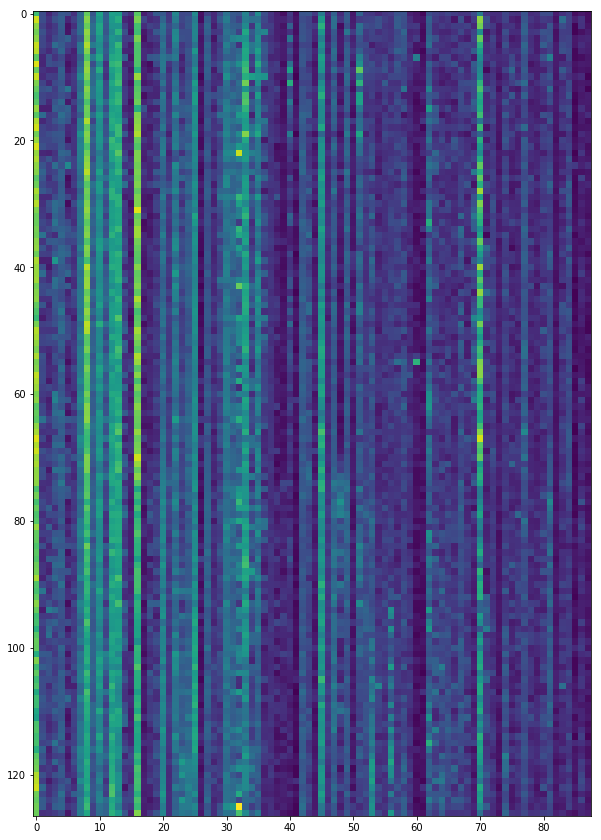

In [26]:
plt.figure(figsize=(10, 20))
plt.imshow(vis_data[topic_cols])

Выводы:

1. Иерархический TM (с вполне хорошим результатом)
2. Довольно грязный код алгоритма (в основном, сейчас занимаюсь им как раз), неудобен в использовании
3. Требовательная к ресурсам модель, часть возможностей алгоритма не реализована (в исходниках есть комментарии)